In [1]:
import mappy as mp
import pandas as pd
import pyfastx
import numpy as np
from pathlib import Path
import regex

# Make DF of reads

In [2]:
def reads_to_df(fastx_file: str) -> pd.DataFrame:
    fastx = pyfastx.Fastx(fastx_file)
    reads = list(zip(*[[x[0], x[1]] for x in fastx]))
    return pd.DataFrame({"name": reads[0], "sequence": reads[1]})

In [3]:
folder = Path("/home/nanopore/sequencing-data/testing-calib-detection/Telobait1/calibration_strands/")
dfs = []
for x in folder.iterdir():
    if x.suffix == ".fastq":
        dfs.append(reads_to_df(str(x)))

In [4]:
df = pd.concat(dfs)

# Map with mappy

## Calculate average alignment score (mlen / seqlen)

In [5]:
def alignment_quality(df: pd.DataFrame):
    a = mp.Aligner("DNA-CS.fasta", preset="map-ont")
    alignment_scores = []
    
    for x in df.itertuples():
        seq = x.sequence
        seq_len = len(seq)
        
        for hit in a.map(seq):
            alignment_scores.append(hit.mlen / max(hit.ctg_len, seq_len))
            
    return np.array(alignment_scores)


In [6]:
alignment_list = alignment_quality(df)
print(np.mean(alignment_list) * 100)
print(len(alignment_list))

95.97876129620585
393


# Look at the Telobaits!

In [7]:
folder = Path("/home/nanopore/sequencing-data/testing-calib-detection/Telobait1/pass/")
dfs = []
for x in folder.iterdir():
    if x.suffix == ".fastq":
        dfs.append(reads_to_df(str(x)))

reads = pd.concat(dfs).reset_index(drop=True)

In [8]:
reads = (
    reads
    .assign(read_len=lambda x: x.sequence.str.len())
)

Mean: 4753.779598825831
Median: 1682.0
Max: 93012


array([[<AxesSubplot: title={'center': 'read_len'}>]], dtype=object)

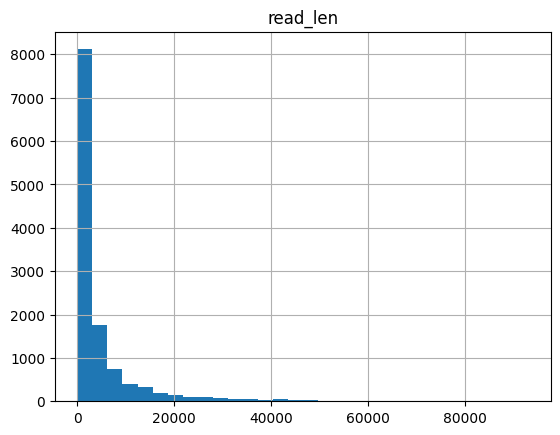

In [9]:
# Average and median read len
print(f"Mean: {reads.read_len.mean()}")
print(f"Median: {reads.read_len.median()}")
print(f"Max: {reads.read_len.max()}")
reads.hist("read_len", bins=30)

# Find the telobaits:
- TGCTCCGTGCATCTGGCATC

* fuzzy_counts = (substitutions, insertions, deletions)

In [10]:
def reverse_comp(seq: str) -> str:
    table = str.maketrans("ACTG", "TGAC")
    return seq.translate(table)[::-1]


In [22]:
capture_motif = "TCCGTGCATCTGGCATCTTGAACCG"
rev_capture_motif = reverse_comp(capture_motif)
subst = 3
# only allow substitutions
motif = f"({capture_motif}){{s<={subst}}}"
rev_motif = f"({rev_capture_motif}){{s<={subst}}}"

In [57]:
def find_motif(motif: str, seq: str, subst: int = 3, rev: bool = False) -> bool:
    if rev:
        motif = f"({reverse_comp(motif)}){{s<={subst}}}" 
        m = regex.search(motif, seq)
        if m is not None:
            diff = len(seq) - m.span()[0]
            if diff < 100:
                return True
        return False
        
    motif = f"({motif}){{s<={subst}}}" 
    m = regex.search(motif, seq)
    if m is not None:
        if m.span()[0] < 100:
            return True
    return False

In [89]:
matches = []
for x in reads.sequence:
    m = regex.search(motif, x)
    if m is not None:
        #if m.span()[0] < 100:
        matches.append(m)
    

In [91]:
print(len(matches))
matches

331


[<regex.Match object; span=(48, 73), match='TCCGTGCATCTGGCATCTTGAACCG'>,
 <regex.Match object; span=(45, 70), match='TCCGTGCATCTGGCATCTTGACCCG', fuzzy_counts=(1, 0, 0)>,
 <regex.Match object; span=(610, 635), match='TCCGTGCATCTGGCATCTTGAACCA', fuzzy_counts=(1, 0, 0)>,
 <regex.Match object; span=(44, 69), match='TCCGTGCATCTGGCATCTTGAACCG'>,
 <regex.Match object; span=(479, 504), match='TCCGTGCATCTGGCATCTTGAACCG'>,
 <regex.Match object; span=(39, 64), match='TCCGTGCATCTGGCATCTTGAACCA', fuzzy_counts=(1, 0, 0)>,
 <regex.Match object; span=(48, 73), match='TCCGTGCATCTGGCATCTTGAACCG'>,
 <regex.Match object; span=(5662, 5687), match='TCCGTGAGTCTGGCATCTTGAACCG', fuzzy_counts=(2, 0, 0)>,
 <regex.Match object; span=(43, 68), match='CTCGTGCATCTGGCATCTTGAACCA', fuzzy_counts=(3, 0, 0)>,
 <regex.Match object; span=(47, 72), match='CTCGTGCATCTGGCATCTTGAACCG', fuzzy_counts=(2, 0, 0)>,
 <regex.Match object; span=(40, 65), match='TCCGTGCATCTGGCATCTTGAACCC', fuzzy_counts=(1, 0, 0)>,
 <regex.Match object;

In [53]:
rev_matches = []
for x in reads.sequence:
    m = regex.search(rev_motif, x)
    if m is not None:
        diff = len(x) - m.span()[0]
        #if diff < 100:
        rev_matches.append(m)

In [56]:
len(rev_matches)

43

In [71]:
telobaits = (
    reads
    .assign(telobait=lambda x: [find_motif("TCCGTGCATCTGGCATCTTGAACCG", y, subst=5, rev=False) for y in x.sequence])
    .loc[lambda x: x.telobait == True]
)

In [72]:
telobaits

,name,sequence,read_len,telobait
138,d9fd259a-f5e5-45ab-b29f-d4d06729ac5c,ATGTTATGTTACATATTTACTTGGTTCCGTTGGTCTTGCTAATTCT...,911,True
140,79f5e626-c4fd-4318-96f4-b847ee9ba1e3,GTGTGATGTTATGTACTTCGTTGAGTTACGTATTGCTAATTCTGCT...,735,True
369,774296cd-308f-46b8-a126-37470c6cdb3a,ATGTTATGTCCTCTACTGGTTCAGTTGGTCTTTGCTAATTCTGCTC...,507,True
502,8e912a3b-f4b5-4669-9488-f47240bc1143,CTATGTAACTTACTTCATTCAGCATATTGTTAATTCTGCTCCGTGC...,677,True
522,86ed2b4d-caaa-4538-945e-d7ea257fcb47,GTGATGTTATGTTATCTACTTCGTTCAGTTACGTATTGTTAATTCT...,9215,True
...,...,...,...,...
12049,3bb5c267-7ed3-4112-bd8c-d920150d0945,GTTATGTTATGTATTTACTTCGTTCAGTTACGTATTGTAATTCTGC...,864,True
12183,d8bb26cf-3c3d-4c7a-bfeb-660d7912ad75,ATTGCTAACCTACTTCGTTCAGTTACGTATTGTTAATTCTGCTCCG...,419,True
12217,cd979ee9-cdfc-4523-9c1c-c8482e1974c1,ATGTTATTATAACCTACTTCGTTCAGTTACGTATTGCAATTCTGCT...,1358,True
12229,0bff6557-2eb3-4de9-aa2f-25eb490981ca,GCTGTTATGTCCTGTTACCTTGGTTCAGTTACGTGTTGCCATTCTT...,4784,True


In [86]:
telomeres = (
    reads
    .assign(telomere=lambda x: 
            np.select(
                [x.sequence.str.contains("CCCTAACCCTAA"), x.sequence.str.contains("TTAGGGTTAGGG")],
                ["CCCTAA", "TTAGGG"],
                default=pd.NA
            )
   )
    .dropna(subset="telomere")
)

In [88]:
telomeres.iloc[3].sequence

'GGCTGTGTTGTGTCCTGTACTTCGTTCAGTTACGTATTGTCATTTCTTTTCACCACAACATGGTGGCCTACAGGGGATCTGTGGCAACCCTGCGGCTGTTTCACTCTGGGGCACTGTCACACTCAGATAGAAACTGACTATCATCCACCCTTCAGCTGCTGAGACTGGCAGAAAATGCTCTTTGCTGACTTTAAGTTGCAGGCTAGATGGTAGGTGACTTTAGTCATAGGTGCAGGACTCCTGCTATGTGCCAAGCACCGTGCCAGGAATTTACACAGACATTGTCTCATTTCCTCATCCACCAAGGGAGGGATGATGAAACCTTCCATACAGGTATCTCCTTAGGACCCAAGGAAATAATATGTATCATAGTGCATTACATGTGACAATTGGAGTAGATCGTTGTTTAAGTATTTCATGTAAAAGTATGTATTCATAGAACATCTAGTATGATCCAAGACCTGTGATAAATCTACCTGAGTTCAAAGATACTTGTTGTAATTAAAACAGGCAAATCAAAAACAATACATTCATGCTTGTTTAAAGAAAATGCTGTAAACAGAAAATTAAAACAAGCACTTAGCAACACATCAGGCACAGGGACCATATCAGAAAGTGTAGAAATGTCTCAGCATTGTGCCCAGTTTGAGACTGGCACTGTCGCCTAGTGACCGGGTAACCCTCCCTGTTTTCTGCTTTCCTAGGTATGCGCAGGGGAACGACCATGGCACTCAGTACCGCTCGGCCATCTACCCGACCTCTGCCAAGCAAATGGAGGCAGCCCTGAGCTCCAAAGAGAACTACCAAAAGGTAGGATTGCTGGGCTCCCTCACCCTGGCTTAGGCCACCATGACTAGGGCCAGGTTCTGATTTTAGAGGGCAGTCTGCTGCTTTTCAACTGGAATTGTGTTTTATTTGCACATATACTTAGAAATTTCTGTCAGCCTCTAGGAGTGGAGCCATTGTGGTCTAATACGTGTGCTAAATGAGGTTTTAAGA